In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np
from line_profiler import LineProfiler
from contextlib import redirect_stdout
jax.config.update("jax_enable_x64", True)

### THE ITERATION PARAMETERs
#physical parameters
delta = 0.012 #interface width
Lambda = delta/(2*jnp.sqrt(2))

gamma_ab = 1e-2 #interface energy between components A,B
gamma_bc = 1e-2
gamma_ca = 1e-2
gamma = jnp.array([gamma_ab, gamma_bc, gamma_ca])

Aa = (9*gamma_ab + 12*(gamma_ca - gamma_bc))/(4*jnp.sqrt(2)*Lambda)
Ab = (9*gamma_ab - 12*(gamma_ca - gamma_bc))/(4*jnp.sqrt(2)*Lambda)
Ac = 3*jnp.sqrt(2)*gamma_ca/Lambda - 4*Aa/3 - Ab/3
A = jnp.array([Aa, Ab, Ac])

C = jnp.max(A + jnp.roll(A, 1))/6

print(jnp.sqrt(2)*Lambda*(Aa + Ab + 2*C)/6)
print(jnp.sqrt(2)*Lambda*(Ac + Ab + 2*C)/6)
print(jnp.sqrt(2)*Lambda*(Aa + Ac + 2*C)/6)
#mean concentration of phase C
mean_uc = 8.74e-2 

'''
h = 2e-6 # time-step (limited by the ODE step but independent of n1)
N = 2000 #num of nodes

该参数下gamma均等于1e-2,是否发生相分离的临界是mean_uc = 8.74e-2
'''

#numerical parameters
stepmax = 150000 # max number of iterations
tol = 5e-8 # parameter used as stopping criterion
h = 2e-6 # time-step (limited by the ODE step but independent of n1)
N = 2000 #num of nodes
eps = 1e-14 #用于处理在计算化学势时P约等于0所引起的numerical error

#meshigird
l = 1
dr = l/N
r = jnp.linspace(0, l, N+1)
r_mid = (r[1:] + r[:-1]) / 2

2024-02-08 14:10:18.826957: W external/org_tensorflow/tensorflow/compiler/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 85045215232


0.010000000000000002
0.010000000000000005
0.010000000000000005


True


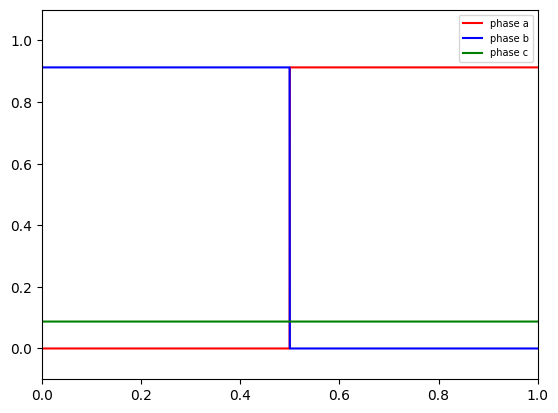

In [2]:
#the initial profile
def initial(x_interface):
    uc = jnp.full(N, mean_uc)
    ua = jnp.full(N, 1 - mean_uc)
    ub = jnp.full(N, 1 - mean_uc)
    check_a = r_mid<x_interface
    check_b = r_mid>x_interface
    ua = jnp.where(check_a, 0, ua)
    ub = jnp.where(check_b, 0, ub)
    return ua, ub, uc

def concentration_profile(ua, ub, uc, gottitle, issavefig, show):
    plt.figure(1)
    plt.plot(r_mid, ua, 'r', label="phase a")
    plt.plot(r_mid, ub, 'b', label="phase b")
    plt.plot(r_mid, uc, 'g', label="phase c")
    plt.legend(fontsize=7)
    if gottitle==True: plt.title(f"final concentration profiles with initial phi-c {mean_uc}")
    plt.xlim(0, 1)
    plt.ylim(-0.1, 1.1)
    if issavefig == True: pass
        #plt.savefig(f"result-{method}/result-c_uniform-{c_uniform}/concentration_profile_2D_{method}_{c_uniform}.png")
    if show == True: plt.show()


ua, ub, uc = initial(x_interface=0.5)
print(jnp.all(ua + ub + uc == 1))#判断全空间上三个组分的浓度是否和为1
concentration_profile(ua, ub, uc, gottitle=False, issavefig=False, show=True)

In [3]:
def laplace_NeumannBoundary(N):
    factor = np.ones(N-1)
    diag1 = np.concatenate([factor, np.array([0.])])
    diag2 = np.concatenate([np.array([0.]), factor])
    diag = - (diag1 + diag2)
    M = np.diag(diag)
    np.fill_diagonal(M[: -1, 1:], factor)  
    np.fill_diagonal(M[1:, : -1], factor) 
    L = jnp.array(M) * N**2
    return L

def gradient_NeumannBoundary(N):
    diag = jnp.zeros(N)
    diag1 = jnp.ones(N-1)
    M = np.diag(diag)
    np.fill_diagonal(M[: -1, 1:], diag1)  
    np.fill_diagonal(M[1:, : -1], -diag1) 
    M[0,0] = -1
    M[-1, -1] = 1
    D = jnp.array(M)*N/2
    return D

L = laplace_NeumannBoundary(N)
D = gradient_NeumannBoundary(N)

print(laplace_NeumannBoundary(5)/(5**2))
print(gradient_NeumannBoundary(5)*2/5)

[[-1.  1.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  1. -1.]]
[[-1.  1.  0.  0.  0.]
 [-1.  0.  1.  0.  0.]
 [ 0. -1.  0.  1.  0.]
 [ 0.  0. -1.  0.  1.]
 [ 0.  0.  0. -1.  1.]]


iteration 0 has done, err 0.8174484072952458
iteration 10000 has done, err 4.0194526245126125e-05
iteration 20000 has done, err 9.653466053822823e-06
iteration 30000 has done, err 3.953823687587055e-06
iteration 40000 has done, err 3.7287495084863646e-06
iteration 50000 has done, err 3.346289163058558e-05
iteration 60000 has done, err 0.0005732490928978248
iteration 70000 has done, err 6.55477021113371e-05
iteration 80000 has done, err 7.136342944764147e-06
iteration 90000 has done, err 8.250516977401988e-07
iteration 100000 has done, err 1.0262720126554921e-07
iteration 110000 has done, err 1.3663964560020845e-08
iteration 120000 has done, err 1.9362102691759354e-09
iteration 130000 has done, err 3.035951698082214e-10
iteration 140000 has done, err 6.76980329442128e-11
[0.99980067 0.99980067 0.99980067 ... 0.99980067 0.99980067 0.99980067]
False
Timer unit: 1e-09 s

Total time: 18.173 s
File: /tmp/ipykernel_1653036/2776112900.py
Function: main_loop at line 27

Line #      Hits        

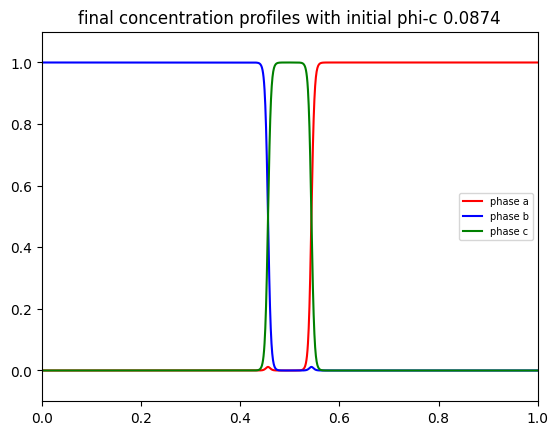

In [4]:
#compute the interface chemical potential
@jax.jit
def cal_ChemicalPotential(i, u, S, P):#u为某一组分i的浓度profile
    mu = 2*A[i]*u*(1 - u)*(1 - 2*u) + 2*C*(u*(S - u**2) - (1-u)*(P + eps)/(jnp.power(1-u, 2) + eps))
    return mu


matrix1 = jnp.linalg.inv(jnp.eye(N) + h*jnp.power(Lambda,2)*(A[0]+C)*jnp.dot(L, L))
matrix2 = jnp.linalg.inv(jnp.eye(N) + h*jnp.power(Lambda,2)*(A[1]+C)*jnp.dot(L, L))
matrix3 = jnp.linalg.inv(jnp.eye(N) + h*jnp.power(Lambda,2)*(A[2]+C)*jnp.dot(L, L))

@jax.jit
def IMEX(ua, ub, uc):
    S = ua**2 + ub**2 +uc**2
    P = jnp.power(1-ua, 2)*jnp.power(1-ub, 2)*jnp.power(1-uc, 2)

    matrix_a = ua + h * jnp.dot(L, cal_ChemicalPotential(0, ua, S, P))
    matrix_b = ub + h * jnp.dot(L, cal_ChemicalPotential(1, ub, S, P))   
    matrix_c = uc + h * jnp.dot(L, cal_ChemicalPotential(2, uc, S, P))

    ua_new = jnp.dot(matrix1, matrix_a)
    ub_new = jnp.dot(matrix2, matrix_b)
    uc_new = jnp.dot(matrix3, matrix_c)
    
    return ua_new, ub_new, uc_new

def main_loop(ua, ub, uc):
    for step in range(stepmax):
        ua0 = ua
        ub0 = ub
        uc0 = uc
        ua, ub, uc = IMEX(ua, ub, uc)
        if step%10000==0: 
            err = (jnp.linalg.norm(ua - ua0) + jnp.linalg.norm(ub - ub0) + jnp.linalg.norm(uc - uc0)) / 3
            print(f"iteration {step} has done, err {err}")
    return ua, ub, uc


lp = LineProfiler()
func = lp(main_loop)
ua, ub, uc = func(ua, ub, uc)
print(ua + ub + uc)
print(jnp.all(ua + ub + uc == 1))#判断全空间上三个组分的浓度是否和为1
lp.print_stats()

concentration_profile(ua, ub, uc, gottitle=True, issavefig=False, show=True)